In [1]:
import os
from typing import Callable, Dict, List, Optional

import numpy as np

import tvm

import tvm.testing
from tvm import ir, te, tir, dlight
from tvm.contrib import nvcc, rpc, utils, ndk
from tvm.script import tir as T, ir as I

In [5]:
############ CUDA
# TARGET = tvm.target.Target("nvidia/geforce-rtx-4090")
# DEVICE = tvm.cuda(0)
# LOAD_V_SHARED = True
# LOAD_V_VEC = 8
# UNROLL = 256
# USE_REMOTE_CL = False

In [3]:
TARGET = tvm.target.Target("metal")
DEVICE = tvm.metal(0)
LOAD_V_SHARED = True
LOAD_V_VEC = 4
UNROLL = 256
USE_REMOTE_CL = False

In [4]:
N = 3072
K = 1024

In [5]:
@T.prim_func
def NK_gemv(
    A: T.Buffer((T.int64(N), T.int64(K)), "float32"),
    V: T.Buffer((T.int64(K)), "float32"), 
    C: T.Buffer((T.int64(N)), "float32")
):
    T.func_attr({"tir.noalias": T.bool(True)})
    # with T.block("root"):
    for i, k in T.grid(T.int64(N), T.int64(K)):
        with T.block("gemv"):
            v_i, v_k = T.axis.remap("SR", [i, k])
            T.reads(V[v_k], A[v_i, v_k])
            T.writes(C[v_i])
            with T.init():
                C[v_i] = T.float16(0)
            C[v_i] = C[v_i] + V[v_k] * A[v_i, v_k]

In [6]:
dlight_sch = dlight.gpu.GEMV().apply(NK_gemv, TARGET, False)
dlight_mod = dlight_sch.mod

CHARLIE 1


In [7]:
print(dlight_mod.script())

# from tvm.script import ir as I
# from tvm.script import tir as T

@I.ir_module
class Module:
    @T.prim_func
    def main(A: T.Buffer((T.int64(3072), T.int64(1024)), "float32"), V: T.Buffer((T.int64(1024),), "float32"), C: T.Buffer((T.int64(3072),), "float32")):
        T.func_attr({"global_symbol": "NK_gemv", "tir.noalias": T.bool(True)})
        # with T.block("root"):
        C_rf_local = T.alloc_buffer((T.int64(256), T.int64(3072)), scope="local")
        C_rf_local_1 = T.alloc_buffer((T.int64(64), T.int64(3072)), scope="local")
        A_local = T.alloc_buffer((T.int64(3072), T.int64(1024)), scope="local")
        for u_fused_ax0_fused_fused_0 in T.thread_binding(T.int64(3072), thread="blockIdx.x"):
            for u_fused_ax0_fused_fused_1 in T.thread_binding(T.int64(1), thread="threadIdx.x"):
                for ax1_fused_u_fused_1_ax1_fused_u_fused_3_fused_0 in T.thread_binding(T.int64(64), thread="threadIdx.y"):
                    for u_fused_ax0_fused_fused_2_init in rang

In [8]:
def prepare_args(func: tir.PrimFunc, var_dict: Dict[str, int]):
    np.random.seed(0)
    args: List[np.ndarray] = []
    analyzer = tvm.arith.Analyzer()
    total_bytes = 0
    for param in func.params:
        buffer = func.buffer_map[param]
        shape = []
        for dim in buffer.shape:
            if isinstance(dim, tir.IntImm):
                shape.append(dim.value)
            elif isinstance(dim, tir.Var):
                assert dim.name in var_dict
                value = var_dict[dim.name]
                shape.append(value)
                analyzer.bind(dim, value)
            else:
                raise ValueError(f"Unknown shape: {buffer.shape}")
        if buffer.dtype == "uint32":
            np_array = np.random.randint(0, 2**16, size=shape).astype(buffer.dtype)
        else:
            np_array = np.random.uniform(high=0.01, size=shape).astype(buffer.dtype)
        total_bytes += np_array.size * np_array.itemsize
        tvm_array = tvm.nd.array(np_array, DEVICE)
        args.append(tvm_array)
    return args, total_bytes

In [9]:
args = prepare_args(dlight_mod["main"], {})
print(len(args[0]))

args_numpy = []

for arg in args[0]:
    print(arg.shape, arg.numpy())
    args_numpy.append(arg.numpy())

print(f"Expected results:", (args_numpy[1] @ args_numpy[0].T))

3
(3072, 1024) [[5.4881349e-03 7.1518938e-03 6.0276338e-03 ... 6.2049991e-03
  6.3962224e-03 9.4854031e-03]
 [7.7827615e-03 8.4834527e-03 4.9041989e-03 ... 9.4382763e-03
  6.8678339e-03 2.8757539e-03]
 [7.6899892e-03 8.3164772e-04 9.7477445e-03 ... 4.0850914e-03
  8.8757987e-04 5.5057891e-03]
 ...
 [7.4058464e-03 1.2562437e-04 9.1892685e-04 ... 5.9952266e-03
  4.7592905e-05 8.1795482e-03]
 [6.9228103e-03 9.3009202e-03 4.6417327e-03 ... 6.2149246e-03
  3.4883290e-03 4.5879078e-03]
 [4.9884580e-03 8.1616250e-04 2.6326692e-03 ... 3.4274033e-03
  9.8919943e-03 8.0181435e-03]]
(1024,) [0.00903195 0.00456826 0.00286234 ... 0.00593346 0.00443424 0.00281718]
(3072,) [0.00412213 0.00313557 0.00639056 ... 0.00516937 0.00209335 0.00592541]
Expected results: [0.02550175 0.02658271 0.02664706 ... 0.02576412 0.02459327 0.02570077]


In [10]:
rt_mod = tvm.build(dlight_mod["main"], target=TARGET)
rt_mod(*args[0])

print(dlight_mod.script())

# from tvm.script import ir as I
# from tvm.script import tir as T

@I.ir_module
class Module:
    @T.prim_func
    def main(A: T.Buffer((T.int64(3072), T.int64(1024)), "float32"), V: T.Buffer((T.int64(1024),), "float32"), C: T.Buffer((T.int64(3072),), "float32")):
        T.func_attr({"global_symbol": "NK_gemv", "tir.noalias": T.bool(True)})
        # with T.block("root"):
        C_rf_local = T.alloc_buffer((T.int64(256), T.int64(3072)), scope="local")
        C_rf_local_1 = T.alloc_buffer((T.int64(64), T.int64(3072)), scope="local")
        A_local = T.alloc_buffer((T.int64(3072), T.int64(1024)), scope="local")
        for u_fused_ax0_fused_fused_0 in T.thread_binding(T.int64(3072), thread="blockIdx.x"):
            for u_fused_ax0_fused_fused_1 in T.thread_binding(T.int64(1), thread="threadIdx.x"):
                for ax1_fused_u_fused_1_ax1_fused_u_fused_3_fused_0 in T.thread_binding(T.int64(64), thread="threadIdx.y"):
                    for u_fused_ax0_fused_fused_2_init in rang

In [12]:
args[0][2].numpy()

array([0.02550175, 0.02658271, 0.02664706, ..., 0.02576412, 0.02459327,
       0.02570077], dtype=float32)

In [13]:
def get_max_factor(n, factors):
    for factor in factors[::-1]:
        if n % factor == 0:
            return factor

In [14]:
cur_best = 1e6
cur_best_dict = None

def build_and_measure(func: tir.PrimFunc, args, total_bytes, config, run_only=False):
    rt_mod = tvm.build(func, target=TARGET)
    rt_mod(*args)
    ret = args[-1]
    if not run_only:
        DEVICE.sync()
        time_eval = rt_mod.time_evaluator(
            rt_mod.entry_name,
            DEVICE,
            # number=20,
            # repeat=3,
            number=1,
            repeat=100,
            cache_flush_bytes=256 * 10**6,
        )
        DEVICE.sync()
        time = time_eval(*args).mean * 1e3
        DEVICE.sync()
        bandwidth = total_bytes / time / (1024**2)

        global cur_best, cur_best_dict
        if time < cur_best and config is not None:
            cur_best = time
            cur_best_dict = config
        print(
            f"Time (ms): {time:.6f}",
            f"Total Bytes (MB): {total_bytes / (1024**2):.6f}",
            f"Memory (GB/s): {bandwidth:.6f}",
            sep="\t",
        )
        
        if config is not None:
            print(
                f"Best time (ms): {cur_best:.6f}",
                f"Best Memory (GB/s): {total_bytes / cur_best / (1024**2):.6f}",
                f"Best config: {cur_best_dict}",
                sep="\t",
            )
        return ret, time
    return ret, -1

In [15]:
TS_data, TR_data, TILE_S_data, TILE_R_data, VEC_LOAD_data, VEC_C_data, times = [],[],[],[],[],[],[]

def schedule1(ret):
    # fmt: off
    # vector load over N, vector compute over K
    def apply(mod):
        # sanity check
        if TILE_S % VEC_LOAD != 0 or TILE_R % 8 != 0:
            return None
        if VEC_LOAD not in [1, 2, 4, 8] or VEC_C not in [1, 2, 4, 8]:
            return None

        # if tx is along s, tile_s should equal to vec_load
        # if tx is along r, tile_r should equal to 8
        # both are required by coalesced load
        if TAG_S == "threadIdx.x" and TILE_S != VEC_LOAD:
            return None
        if TAG_R == "threadIdx.x" and TILE_R != 8:
            return None
    
        sch = tir.Schedule(mod)
        gemv = sch.get_block(name="gemv", func_name="main")

        # rfactor: reduce to tx * vec_c
        s, r = sch.get_loops(block=gemv)
        bx, ts, tile_s = sch.split(s, factors=[None, TS, TILE_S], preserve_unit_iters=True)
        r, tr, tile_r_vec_n, vec_c = sch.split(r, factors=[None, TR, TILE_R // VEC_C, VEC_C], preserve_unit_iters=True)
        sch.reorder(r, tile_r_vec_n, tr, vec_c)
        tr_vec_c = sch.fuse(tr, vec_c)
        rf = sch.rfactor(tr_vec_c, 0)

        # rfactor: reduce to tx
        bx, ts, tile_s, tr_vec_c = sch.get_loops(block=gemv)
        tr, vec_c = sch.split(tr_vec_c, factors=[TR, None], preserve_unit_iters=True)
        rf2 = sch.rfactor(tr, 0)

        # bind, vectorize compute
        bx, ts, tile_s, r, tile_r_vec_n, tr_vec_c = sch.get_loops(block=rf)
        tr, vec_c = sch.split(tr_vec_c, factors=[TR, None], preserve_unit_iters=True)
        sch.reorder(bx, ts, tr, r, tile_s, tile_r_vec_n, vec_c)
        sch.bind(bx, "blockIdx.x")
        sch.bind(ts, TAG_S)
        sch.bind(tr, TAG_R)
        sch.vectorize(vec_c)

        # vectorize load A
        Aq_local = sch.cache_read(rf, read_buffer_index=1, storage_scope="local")
        sch.compute_at(Aq_local, r, preserve_unit_loops=True)
        s_local, r_local = sch.get_loops(block=Aq_local)[-2:]
        s_local, vec_load = sch.split(
            s_local, factors=[None, VEC_LOAD], preserve_unit_iters=True
        )
        sch.reorder(s_local, r_local, vec_load)  # either s_local or r_local should be 1
        sch.vectorize(vec_load)

        # load vector into shared memory, shape should be the whole vector
        if LOAD_V_SHARED:
            V_shared = sch.cache_read(rf, read_buffer_index=0, storage_scope="shared")
            sch.compute_at(V_shared, tr, preserve_unit_loops=True)
            l = sch.get_loops(block=V_shared)[-1]
            loop: tir.For = sch.get(l)
            if isinstance(loop.extent, tir.IntImm):
                # avoid introducing predicates when vector length is too large
                vec_length = max(
                    min(
                        get_max_factor(
                            (int)(loop.extent),
                            [TS * TR * 1, TS * TR * 2, TS * TR * 4, TS * TR * 8],
                        )
                        // TS
                        // TR,
                        LOAD_V_VEC,
                    ),
                    1,
                )
            else:
                vec_length = LOAD_V_VEC
            if TAG_R == "threadIdx.x":
                _, ty, tx, vec = sch.split(
                    l, factors=[None, TS, TR, vec_length], preserve_unit_iters=True
                )
            else:
                _, ty, tx, vec = sch.split(
                    l, factors=[None, TR, TS, vec_length], preserve_unit_iters=True
                )
            sch.bind(ty, "threadIdx.y")
            sch.bind(tx, "threadIdx.x")
            sch.vectorize(vec)

        # reduce tile_s * tr * vec to tile_s * tr
        sch.reverse_compute_at(rf2, loop=bx, preserve_unit_loops=True)
        tr, vec_c, *ts_tile_s = sch.get_loops(block=rf2)[1:]
        ts_tile_s = sch.fuse(*ts_tile_s)
        ts, tile_s = sch.split(ts_tile_s, factors=[TS, None], preserve_unit_iters=True)
        tile_s, vec_s = sch.split(
            tile_s,
            factors=[None, get_max_factor(TILE_S, [1, 2, 4, 8])],
            preserve_unit_iters=True,
        )
        sch.reorder(ts, tr, tile_s, vec_s, vec_c)
        sch.bind(ts, TAG_S)
        sch.bind(tr, TAG_R)
        sch.vectorize(vec_s)

        # reduce tile_s * tr to tile_s
        sch.reverse_compute_at(gemv, loop=bx, preserve_unit_loops=True)
        tr, *ts_tile_s = sch.get_loops(block=gemv)[1:]
        ts_tile_s = sch.fuse(*ts_tile_s)
        ts, tile_s = sch.split(ts_tile_s, factors=[TS, None], preserve_unit_iters=True)
        sch.reorder(tile_s, ts, tr)
        sch.bind(ts, TAG_S)
        sch.bind(tr, TAG_R)

        sch.decompose_reduction(rf, loop=sch.get_loops(block=rf)[3])
        sch.decompose_reduction(rf2, loop=sch.get_loops(block=rf2)[-1])

        sch.set_scope(rf, buffer_index=0, storage_scope="local")
        sch.set_scope(rf2, buffer_index=0, storage_scope="local")

        unroll_factor = UNROLL

        sch.annotate(
            block_or_loop=sch.get_loops(rf)[3],
            ann_key="pragma_auto_unroll_max_step",
            ann_val=unroll_factor,
        )
        sch.annotate(
            block_or_loop=sch.get_loops(rf)[3], ann_key="pragma_unroll_explicit", ann_val=1
        )

        sch.annotate(
            block_or_loop=sch.get_loops(rf2)[3],
            ann_key="pragma_auto_unroll_max_step",
            ann_val=unroll_factor,
        )
        sch.annotate(
            block_or_loop=sch.get_loops(rf2)[3], ann_key="pragma_unroll_explicit", ann_val=1
        )

        if LOAD_V_SHARED:
            sch.annotate(
                block_or_loop=sch.get_loops(V_shared)[-4],
                ann_key="pragma_unroll_explicit",
                ann_val=unroll_factor,
            )
            sch.annotate(
                block_or_loop=sch.get_loops(V_shared)[-4], ann_key="pragma_vectorize", ann_val=1
            )

        return sch

    for TAG_S, TAG_R in [
        ("threadIdx.x", "threadIdx.y")
    ]:
        for VEC_LOAD in [1, 2, 4]:
            for VEC_C in [4, 2]:
                for TILE_S in [1, 2, 4]:
                    for TILE_R in [1]:
                        TILE_R = TILE_R * 8
                        for all_thread in [512, 256, 128, 64, 32]:
                            for TR in [1, 2, 4, 8, 16, 32, 64, 128, 256]:
                                TS = all_thread // TR
                                if TS <= 0 or TR <= 0:
                                    continue
                                sch = apply(NK_gemv)
                                if sch is None:
                                    continue
                                try:
                                    print("====")
                                    print(
                                        f"schedule 1: TAG_S={TAG_S}",
                                        f"TAG_R={TAG_R}",
                                        f"vec_load={VEC_LOAD}",
                                        f"vec_c={VEC_C}",
                                        f"tile_s={TILE_S}",
                                        f"tile_r={TILE_R}",
                                        f"tr={TR}",
                                        f"ts={TS}",
                                        sep="\t",
                                    )

                                    # sch.mod.show(black_format=False)
                                    sch_args = prepare_args(NK_gemv, {})
                                    ret_cur, time = build_and_measure(
                                        sch.mod["main"],
                                        sch_args[0],
                                        sch_args[1],
                                        config={
                                            "TAG_S": TAG_S,
                                            "TAG_R": TAG_R,
                                            "VEC_LOAD": VEC_LOAD,
                                            "VEC_C": VEC_C,
                                            "TILE_S": TILE_S,
                                            "TILE_R": TILE_R,
                                            "TR": TR,
                                            "TS": TS
                                        },
                                    )
                                    TS_data.append(TS)
                                    TR_data.append(TR)
                                    TILE_S_data.append(TILE_S)
                                    TILE_R_data.append(TILE_R)
                                    VEC_LOAD_data.append(VEC_LOAD)
                                    VEC_C_data.append(VEC_C)
                                    times.append(time)

                                    print("Tested")
                                    tvm.testing.assert_allclose(
                                        ret.numpy(),
                                        ret_cur.numpy(),
                                        rtol=5e-2,
                                        atol=5e-2,
                                    )
                                    # export_source(sch.mod["main"])
                                except Exception as e:
                                    print("Error", e)

In [16]:
# dlight default benchmark:
ret, time = build_and_measure(dlight_mod["main"], *args, None, run_only=False)

Time (ms): 0.211259	Total Bytes (MB): 12.015625	Memory (GB/s): 56.876221


[02:23:12] /Users/cfruan/Documents/tvm-unity/src/runtime/profiling.cc:101: Warning: No timer implementation for metal, using default timer instead. It may be inaccurate or have extra overhead.


In [17]:
schedule1(ret)

====
schedule 1: TAG_S=threadIdx.x	TAG_R=threadIdx.y	vec_load=1	vec_c=4	tile_s=1	tile_r=8	tr=1	ts=512
Time (ms): 0.295892	Total Bytes (MB): 12.015625	Memory (GB/s): 40.608132
Best time (ms): 0.295892	Best Memory (GB/s): 40.608132	Best config: {'TAG_S': 'threadIdx.x', 'TAG_R': 'threadIdx.y', 'VEC_LOAD': 1, 'VEC_C': 4, 'TILE_S': 1, 'TILE_R': 8, 'TR': 1, 'TS': 512}
Tested
====
schedule 1: TAG_S=threadIdx.x	TAG_R=threadIdx.y	vec_load=1	vec_c=4	tile_s=1	tile_r=8	tr=2	ts=256
Time (ms): 0.262834	Total Bytes (MB): 12.015625	Memory (GB/s): 45.715617
Best time (ms): 0.262834	Best Memory (GB/s): 45.715617	Best config: {'TAG_S': 'threadIdx.x', 'TAG_R': 'threadIdx.y', 'VEC_LOAD': 1, 'VEC_C': 4, 'TILE_S': 1, 'TILE_R': 8, 'TR': 2, 'TS': 256}
Tested
====
schedule 1: TAG_S=threadIdx.x	TAG_R=threadIdx.y	vec_load=1	vec_c=4	tile_s=1	tile_r=8	tr=4	ts=128
Time (ms): 0.247959	Total Bytes (MB): 12.015625	Memory (GB/s): 48.458159
Best time (ms): 0.247959	Best Memory (GB/s): 48.458159	Best config: {'TAG_S': 'th

In [18]:
print("TS", TS_data) 
print("TR", TR_data)
print("TILE_S", TILE_S_data)
print("TILE_R", TILE_R_data)
print("VEC_LOAD", VEC_LOAD_data)
print("VEC_C", VEC_C_data)
print("times", times)

print(len(TS_data), len(TR_data), len(TILE_S_data), len(TILE_R_data), len(VEC_LOAD_data), len(VEC_C_data), len(times))

TS [512, 256, 128, 32, 16, 8, 4, 2, 256, 128, 64, 32, 16, 8, 4, 2, 1, 128, 64, 32, 16, 8, 4, 2, 1, 64, 32, 16, 8, 4, 2, 1, 32, 16, 8, 4, 2, 1, 512, 256, 128, 32, 16, 8, 4, 2, 256, 128, 64, 32, 16, 8, 4, 2, 1, 128, 64, 32, 16, 8, 4, 2, 1, 64, 32, 16, 8, 4, 2, 1, 32, 16, 8, 4, 2, 1, 512, 256, 128, 16, 8, 4, 2, 256, 128, 64, 32, 16, 8, 4, 2, 1, 128, 64, 32, 16, 8, 4, 2, 1, 64, 32, 16, 8, 4, 2, 1, 32, 16, 8, 4, 2, 1, 512, 256, 128, 16, 8, 4, 2, 256, 128, 64, 32, 16, 8, 4, 2, 1, 128, 64, 32, 16, 8, 4, 2, 1, 64, 32, 16, 8, 4, 2, 1, 32, 16, 8, 4, 2, 1, 512, 256, 128, 8, 4, 2, 256, 128, 64, 32, 16, 8, 4, 2, 1, 128, 64, 32, 16, 8, 4, 2, 1, 64, 32, 16, 8, 4, 2, 1, 32, 16, 8, 4, 2, 1, 512, 256, 128, 64, 8, 4, 2, 256, 128, 64, 32, 16, 8, 4, 2, 1, 128, 64, 32, 16, 8, 4, 2, 1, 64, 32, 16, 8, 4, 2, 1, 32, 16, 8, 4, 2, 1]
TR [1, 2, 4, 16, 32, 64, 128, 256, 1, 2, 4, 8, 16, 32, 64, 128, 256, 1, 2, 4, 8, 16, 32, 64, 128, 1, 2, 4, 8, 16, 32, 64, 1, 2, 4, 8, 16, 32, 1, 2, 4, 16, 32, 64, 128, 256, 1, 2, 4, 

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = {
    "TS": TS_data,
    "TR": TR_data,
    "TILE_S": TILE_S_data,
    "TILE_R": TILE_R_data,
    "VEC_LOAD": VEC_LOAD_data,
    "VEC_C": VEC_C_data,
    "times": times
}

df = pd.DataFrame(data)
filtered_df = df[(df['TILE_S'] == 2) & (df['TILE_R'] == 8) & (df['VEC_LOAD'] == 2) & (df['VEC_C'] == 4)]
filtered_df

,TS,TR,TILE_S,TILE_R,VEC_LOAD,VEC_C,times
76,512,1,2,8,2,4,0.414675
77,256,2,2,8,2,4,0.295837
78,128,4,2,8,2,4,0.231323
79,16,32,2,8,2,4,0.203556
80,8,64,2,8,2,4,0.208072
81,4,128,2,8,2,4,0.197447
82,2,256,2,8,2,4,0.287618
83,256,1,2,8,2,4,0.294053
84,128,2,2,8,2,4,0.228887
85,64,4,2,8,2,4,0.242067


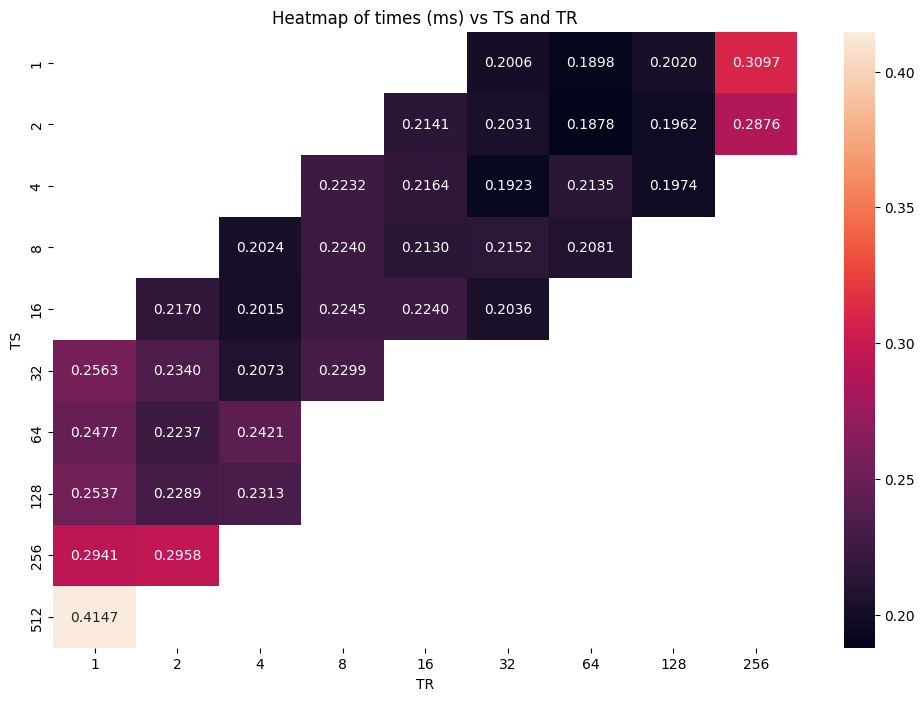

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Creating a pivot table
pivot_table = filtered_df.pivot_table(values='times', index='TS', columns='TR', aggfunc='mean')

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".4f")
plt.title('Heatmap of times (ms) vs TS and TR')
plt.xlabel('TR')
plt.ylabel('TS')
plt.show()

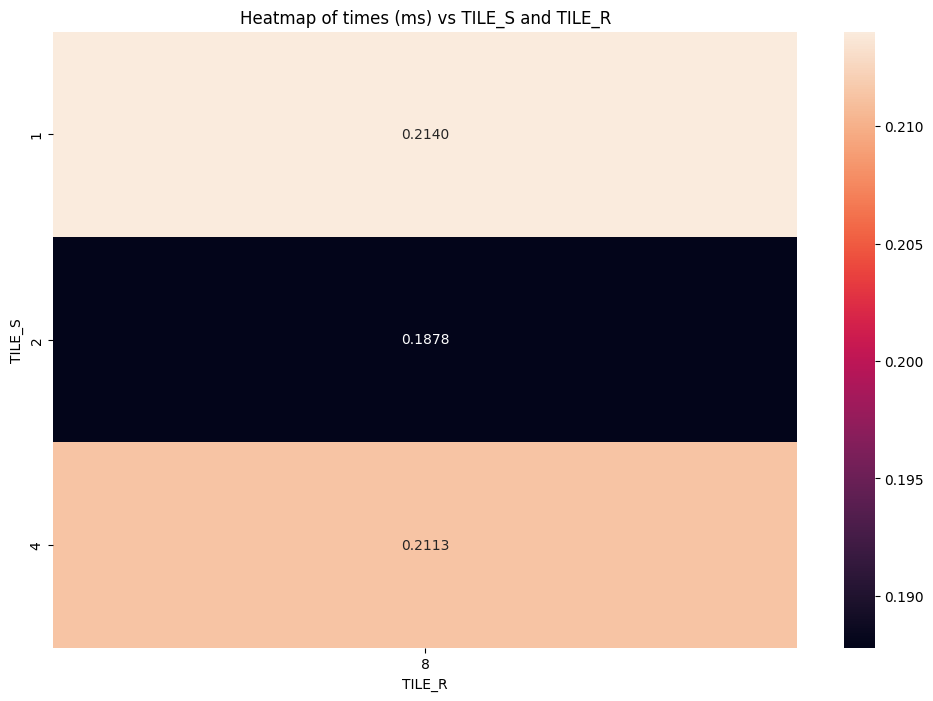

In [23]:
filtered_df = df[(df['TS'] == 2) & (df['TR'] == 64) & (df['VEC_C'] == 4)]
filtered_df

# Creating a pivot table
pivot_table = filtered_df.pivot_table(values='times', index='TILE_S', columns='TILE_R', aggfunc='mean')

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".4f")
plt.title('Heatmap of times (ms) vs TILE_S and TILE_R')
plt.xlabel('TILE_R')
plt.ylabel('TILE_S')
plt.show()

In [24]:
cur_best = 1e6
cur_best_dict = None

TS_data, TR_data, TILE_S_data, TILE_R_data, VEC_LOAD_data, VEC_C_data, times = [],[],[],[],[],[],[]

def schedule2(ret):
    # fmt: off
    # vector load over K, vector compute over K
    def apply(mod):
        # sanity check
        if (TILE_R // 8) % VEC_LOAD != 0 or TILE_R % 8 != 0:
            return None
        if VEC_LOAD not in [1, 2, 4, 8] or VEC_C not in [1, 2, 4, 8]:
            return None

        # if tx is along s, tile_s should equal to 1
        # if tx is along r, tile_r should equal to vec_load * 8
        # if n > 1 and tx is along s, k should be at least vec_load
        # both are required by coalesced load
        if TAG_S == "threadIdx.x" and TILE_S != 1:
            return None
        if TAG_R == "threadIdx.x" and TILE_R != 8 * vec_load:
            return None
        

        sch = tir.Schedule(mod)
        gemv = sch.get_block(name="gemv", func_name="main")

        # rfactor: reduce to tx * vec_c
        s, r = sch.get_loops(block=gemv)
        bx, ts, tile_s = sch.split(s, factors=[None, TS, TILE_S], preserve_unit_iters=True)
        r, tr, tile_r_vec_n, vec_c = sch.split(r, factors=[None, TR, TILE_R // VEC_C, VEC_C], preserve_unit_iters=True)
        sch.reorder(r, tile_r_vec_n, tr, vec_c)
        tr_vec_c = sch.fuse(tr, vec_c)
        rf = sch.rfactor(tr_vec_c, 0)

        # rfactor: reduce to tx
        bx, ts, tile_s, tr_vec_c = sch.get_loops(block=gemv)
        tr, vec_c = sch.split(tr_vec_c, factors=[TR, None], preserve_unit_iters=True)
        rf2 = sch.rfactor(tr, 0)

        # bind, vectorize compute
        bx, ts, tile_s, r, tile_r_vec_n, tr_vec_c = sch.get_loops(block=rf)
        tr, vec_c = sch.split(tr_vec_c, factors=[TR, None], preserve_unit_iters=True)
        sch.reorder(bx, ts, tr, r, tile_s, tile_r_vec_n, vec_c)
        sch.bind(bx, "blockIdx.x")
        sch.bind(ts, TAG_S)
        sch.bind(tr, TAG_R)
        sch.vectorize(vec_c)

        # vectorize load A
        Aq_local = sch.cache_read(rf, read_buffer_index=1, storage_scope="local")
        sch.compute_at(Aq_local, r, preserve_unit_loops=True)
        s_local, r_local = sch.get_loops(block=Aq_local)[-2:]
        s_local, vec_load = sch.split(
            s_local, factors=[None, VEC_LOAD], preserve_unit_iters=True
        )
        sch.reorder(s_local, r_local, vec_load)  # either s_local or r_local should be 1
        sch.vectorize(vec_load)
        
        # load vector into shared memory, shape should be the whole vector
        if LOAD_V_SHARED:
            V_shared = sch.cache_read(rf, read_buffer_index=0, storage_scope="shared")
            sch.compute_at(V_shared, tr, preserve_unit_loops=True)
            l = sch.get_loops(block=V_shared)[-1]
            loop: tir.For = sch.get(l)
            if isinstance(loop.extent, tir.IntImm):
                # avoid introducing predicates when vector length is too large
                vec_length = min(int(loop.extent) // TR // TS, LOAD_V_VEC)
            else:
                vec_length = LOAD_V_VEC
            if TAG_R == "threadIdx.x":
                _, ty, tx, vec = sch.split(l, factors=[None, TS, TR, vec_length], preserve_unit_iters=True)
            else:
                _, ty, tx, vec = sch.split(l, factors=[None, TR, TS, vec_length], preserve_unit_iters=True)
            sch.bind(ty, "threadIdx.y")
            sch.bind(tx, "threadIdx.x")
            sch.vectorize(vec)

        # reduce tile_s * tr * vec to tile_s * tr
        sch.reverse_compute_at(rf2, loop=bx, preserve_unit_loops=True)
        tr, vec_c, ts_tile_s = sch.get_loops(block=rf2)[-3:]
        ts, tile_s = sch.split(ts_tile_s, factors=[TS, None], preserve_unit_iters=True)
        tile_s, vec_s = sch.split(tile_s, factors=[None, get_max_factor(TILE_S, [1, 2, 4, 8])], preserve_unit_iters=True)
        sch.reorder(ts, tr, tile_s, vec_s, vec_c)
        sch.bind(ts, TAG_S)
        sch.bind(tr, TAG_R)
        sch.vectorize(vec_s)
        
        # reduce tile_s * tr to tile_s
        sch.reverse_compute_at(gemv, loop=bx, preserve_unit_loops=True)
        tr, ts_tile_s = sch.get_loops(block=gemv)[-2:]
        ts, tile_s = sch.split(ts_tile_s, factors=[TS, None], preserve_unit_iters=True)
        sch.reorder(tile_s, ts, tr)
        sch.bind(ts, TAG_S)
        sch.bind(tr, TAG_R)
        
        sch.decompose_reduction(rf, loop=sch.get_loops(block=rf)[3])
        sch.decompose_reduction(rf2, loop=sch.get_loops(block=rf2)[-1])
        
        sch.set_scope(rf, buffer_index=0, storage_scope="local")
        sch.set_scope(rf2, buffer_index=0, storage_scope="local")

        unroll_factor = UNROLL

        sch.annotate(block_or_loop=sch.get_loops(rf)[3], ann_key="pragma_auto_unroll_max_step", ann_val=unroll_factor)
        sch.annotate(block_or_loop=sch.get_loops(rf)[3], ann_key="pragma_unroll_explicit", ann_val=1)

        sch.annotate(block_or_loop=sch.get_loops(rf2)[3], ann_key="pragma_auto_unroll_max_step", ann_val=unroll_factor)
        sch.annotate(block_or_loop=sch.get_loops(rf2)[3], ann_key="pragma_unroll_explicit", ann_val=1)

        if LOAD_V_SHARED:
            sch.annotate(block_or_loop=sch.get_loops(V_shared)[-4], ann_key="pragma_unroll_explicit", ann_val=unroll_factor)
            sch.annotate(block_or_loop=sch.get_loops(V_shared)[-4], ann_key="pragma_vectorize", ann_val=1)

        return sch

    for TAG_S, TAG_R in [
        ("threadIdx.x", "threadIdx.y")
    ]:
        for VEC_LOAD in [4, 2, 1]:
            for VEC_C in [4]:
                for TILE_S in [1]:
                    for TILE_R in [4, 2, 1]:
                        TILE_R = TILE_R * 8
                        for all_thread in [512, 256, 128, 64, 32]:
                            for TR in [1, 2, 4, 8, 16, 32, 64, 128, 256]:
                                TS = all_thread // TR
                                if TS <= 0 or TR <= 0:
                                    continue
                                sch = apply(NK_gemv)
                                if sch is None:
                                    continue
                                try:
                                    print("====")
                                    print(
                                        f"schedule 2: TAG_S={TAG_S}",
                                        f"TAG_R={TAG_R}",
                                        f"vec_load={VEC_LOAD}",
                                        f"vec_c={VEC_C}",
                                        f"tile_s={TILE_S}",
                                        f"tile_r={TILE_R}",
                                        f"tr={TR}",
                                        f"ts={TS}",
                                        sep="\t",
                                    )
                                    # sch.mod.show(black_format=False)
                                    sch_args = prepare_args(NK_gemv, {})
                                    ret_cur, time = build_and_measure(
                                        sch.mod["main"],
                                        sch_args[0],
                                        sch_args[1],
                                        config={
                                            "TAG_S": TAG_S,
                                            "TAG_R": TAG_R,
                                            "VEC_LOAD": VEC_LOAD,
                                            "VEC_C": VEC_C,
                                            "TILE_S": TILE_S,
                                            "TILE_R": TILE_R,
                                            "TR": TR,
                                            "TS": TS,
                                        },
                                    )

                                    TS_data.append(TS)
                                    TR_data.append(TR)
                                    TILE_S_data.append(TILE_S)
                                    TILE_R_data.append(TILE_R)
                                    VEC_LOAD_data.append(VEC_LOAD)
                                    VEC_C_data.append(VEC_C)
                                    times.append(time)

                                    tvm.testing.assert_allclose(
                                        ret.numpy(),
                                        ret_cur.numpy(),
                                        rtol=5e-2,
                                        atol=5e-2,
                                    )
                                    # export_source(sch.mod["main"])
                                except Exception as e:
                                    print("Error", e)

In [25]:
schedule2(ret)

====
schedule 2: TAG_S=threadIdx.x	TAG_R=threadIdx.y	vec_load=4	vec_c=4	tile_s=1	tile_r=32	tr=1	ts=512
Time (ms): 0.270126	Total Bytes (MB): 12.015625	Memory (GB/s): 44.481507
Best time (ms): 0.270126	Best Memory (GB/s): 44.481507	Best config: {'TAG_S': 'threadIdx.x', 'TAG_R': 'threadIdx.y', 'VEC_LOAD': 4, 'VEC_C': 4, 'TILE_S': 1, 'TILE_R': 32, 'TR': 1, 'TS': 512}
====
schedule 2: TAG_S=threadIdx.x	TAG_R=threadIdx.y	vec_load=4	vec_c=4	tile_s=1	tile_r=32	tr=2	ts=256
Time (ms): 0.229288	Total Bytes (MB): 12.015625	Memory (GB/s): 52.404091
Best time (ms): 0.229288	Best Memory (GB/s): 52.404091	Best config: {'TAG_S': 'threadIdx.x', 'TAG_R': 'threadIdx.y', 'VEC_LOAD': 4, 'VEC_C': 4, 'TILE_S': 1, 'TILE_R': 32, 'TR': 2, 'TS': 256}
====
schedule 2: TAG_S=threadIdx.x	TAG_R=threadIdx.y	vec_load=4	vec_c=4	tile_s=1	tile_r=32	tr=4	ts=128
Time (ms): 0.218711	Total Bytes (MB): 12.015625	Memory (GB/s): 54.938414
Best time (ms): 0.218711	Best Memory (GB/s): 54.938414	Best config: {'TAG_S': 'threadIdx.x

In [31]:
data = {
    "TS": TS_data,
    "TR": TR_data,
    "TILE_S": TILE_S_data,
    "TILE_R": TILE_R_data,
    "VEC_LOAD": VEC_LOAD_data,
    "VEC_C": VEC_C_data,
    "times": times
}

df = pd.DataFrame(data)
filtered_df = df[(df['TILE_S'] == 1) & (df['TILE_R'] == 16) & (df['VEC_LOAD'] == 1) & (df['VEC_C'] == 4)]
filtered_df

,TS,TR,TILE_S,TILE_R,VEC_LOAD,VEC_C,times
155,512,1,1,16,1,4,0.253687
156,256,2,1,16,1,4,0.222352
157,128,4,1,16,1,4,0.213154
158,32,16,1,16,1,4,0.204792
159,16,32,1,16,1,4,0.203050
160,8,64,1,16,1,4,0.196980
161,4,128,1,16,1,4,0.269048
162,2,256,1,16,1,4,0.262486
163,256,1,1,16,1,4,0.220842
164,128,2,1,16,1,4,0.224645


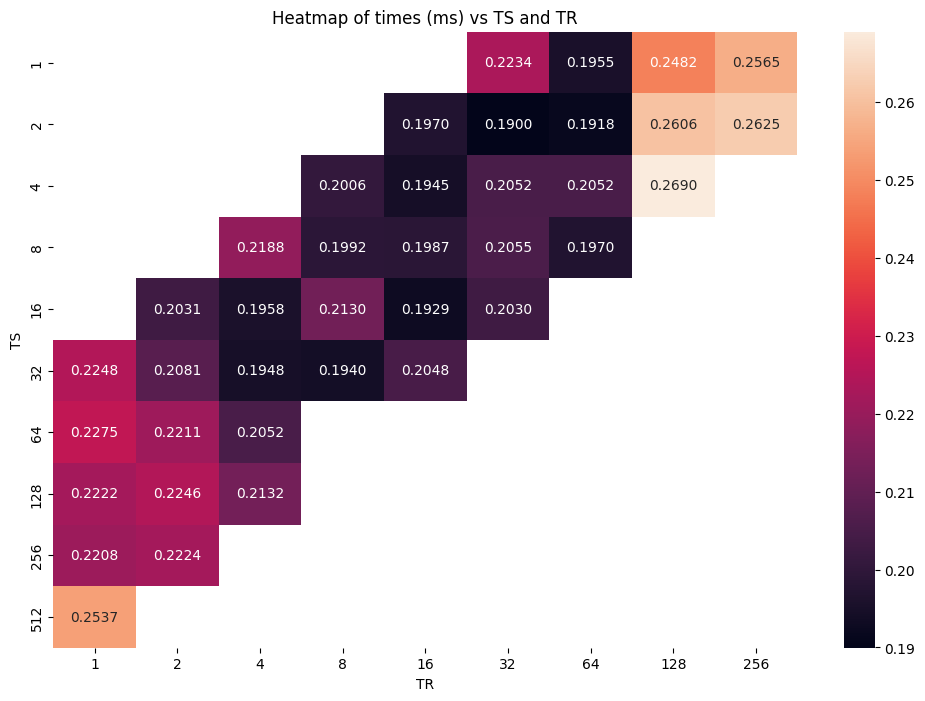

In [32]:
# Creating a pivot table
pivot_table = filtered_df.pivot_table(values='times', index='TS', columns='TR', aggfunc='mean')

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".4f")
plt.title('Heatmap of times (ms) vs TS and TR')
plt.xlabel('TR')
plt.ylabel('TS')
plt.show()

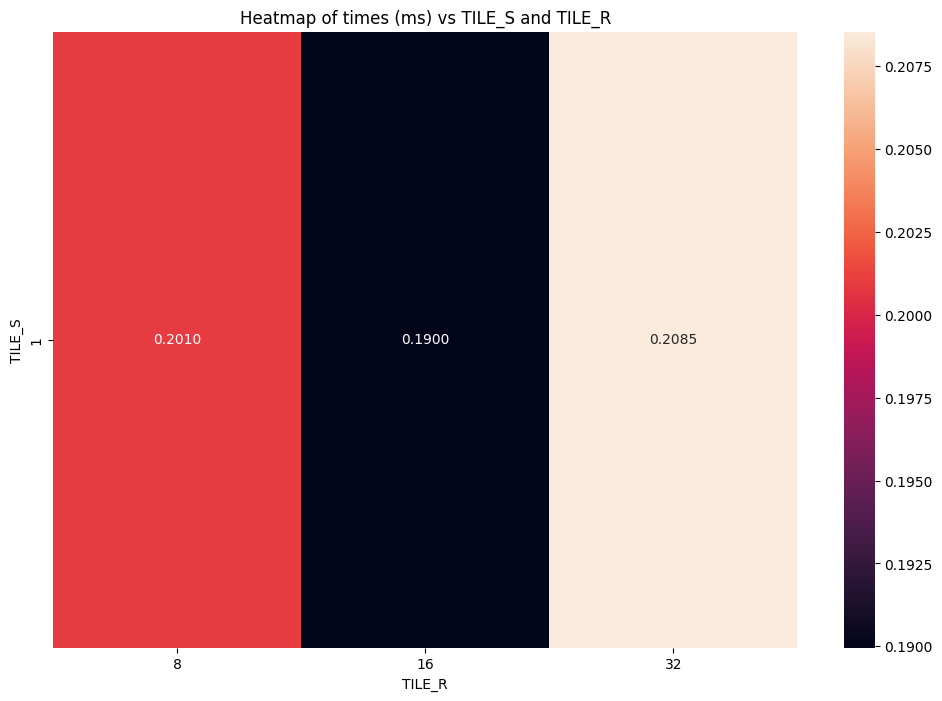

In [34]:
filtered_df = df[(df['TS'] == 2) & (df['TR'] == 32) & (df['VEC_C'] == 4)]
filtered_df

# Creating a pivot table
pivot_table = filtered_df.pivot_table(values='times', index='TILE_S', columns='TILE_R', aggfunc='min')

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".4f")
plt.title('Heatmap of times (ms) vs TILE_S and TILE_R')
plt.xlabel('TILE_R')
plt.ylabel('TILE_S')
plt.show()